In [14]:
#Here is the presentation version of my codes. 
#As I have to test different indicators, I changed some variables to make my slides. I did not show that in codes below.

In [15]:
import hmmlearn
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import os
import seaborn as sns

In [16]:
#read data
sns.set_style('white')
os.chdir(r"C:\Users\czy\Desktop\课程\topics")
data=pd.read_csv('indicators.csv')
data=data.set_index('date')

In [17]:
#initialize
data=data[:3000]
data_test=data[3000:]
volume=data["volume"].values
close = data['close'].values
open_price=data['open'].values
high = data['high'].values
low = data['low'].values
swing=data['swing'].values

logreturn = (np.log(np.array(close[1:]))-np.log(np.array(close[:-1])))[4:]
logreturn5 = np.log(np.array(close[5:]))-np.log(np.array(close[:-5]))
logvolume=(np.log(np.array(volume[1:]))-np.log(np.array(volume[:-1])))[4:]
diffreturn = (np.array(high)-np.array(low))/np.array(close)       
diffreturn=diffreturn[5:]
swing=swing[5:]

In [18]:
#hmm learning
X = np.column_stack([logreturn,logreturn5])
hmm = GaussianHMM(n_components = 6, covariance_type='diag',n_iter = 5000).fit(X)
latent_states_sequence = hmm.predict(X)

C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWar

In [19]:
datelist = pd.to_datetime(data['close'].index[5:])
closeidx = close[5:]

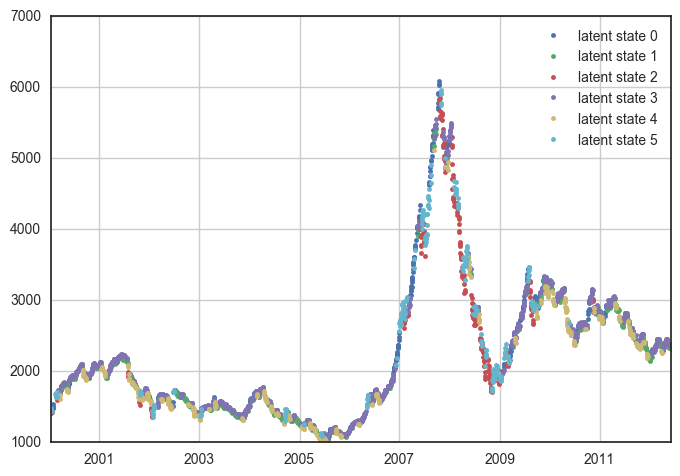

In [20]:
#plot market state sequence
sns.set_style('white')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    plt.plot(datelist[state],closeidx[state],'.',label = 'latent state %d'%i,lw = 1)
    plt.legend()
    plt.grid(1)
plt.show()

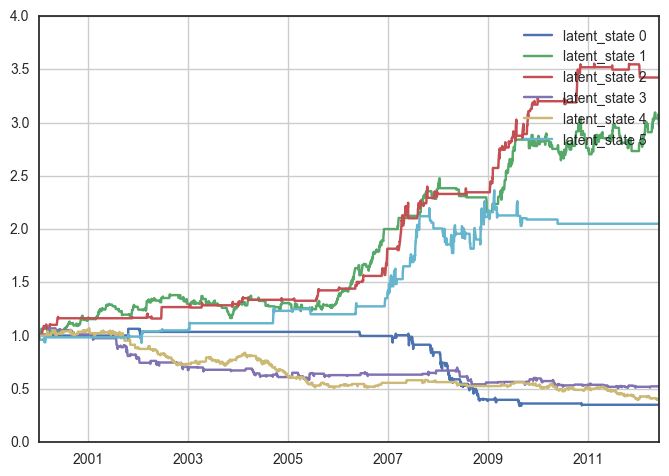

In [7]:
#test latent state. Use single latent state to guide trading.
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn,'state':latent_states_sequence}).set_index('datelist')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[:-1])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i) 
    plt.legend()
    plt.grid(1)
    
plt.show()

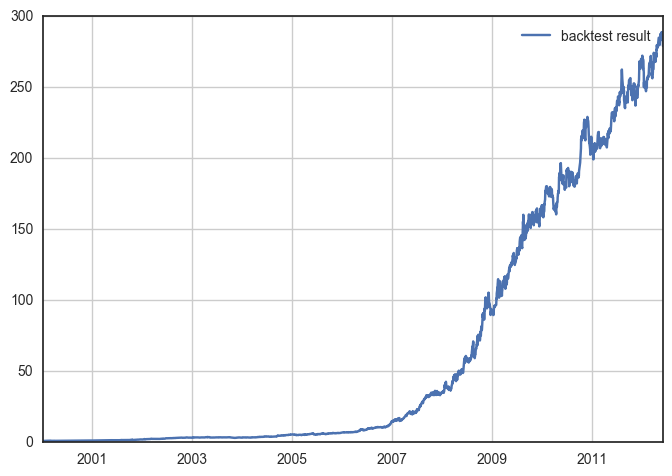

In [8]:
#construct strategy. As I test the latent states, I know which state means buy, which means sell.
buy=0;
sell=0;
for i in range(hmm.n_components):
    temp=np.exp(data['state %d_return' %i].cumsum())
    if temp[-1]>1.2 :
        buy=buy+(latent_states_sequence == i)
    if temp[-1]<1 :
        sell=sell+(latent_states_sequence == i)
buy = np.append(0,buy[:-1])
sell = np.append(0,sell[:-1])
data['backtest_return'] = data.logreturn.multiply(buy,axis = 0) \
                             - data.logreturn.multiply(sell,axis = 0)
plt.plot_date(datelist,np.exp(data['backtest_return'].cumsum()),'-',label='backtest result')
plt.legend()
plt.grid(1)
plt.show()

C:\Software\anaconda\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


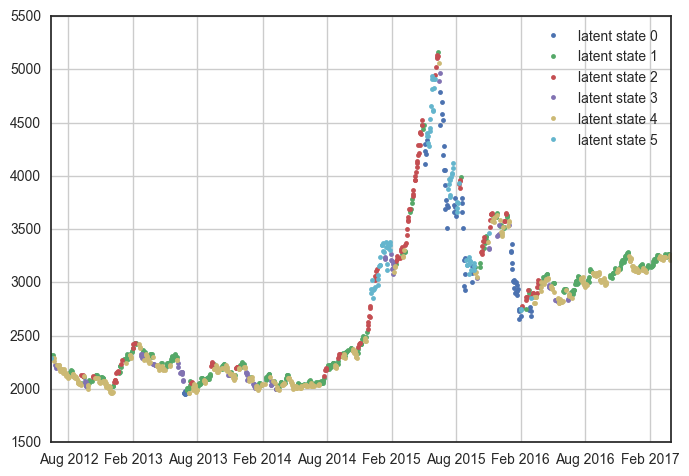

In [9]:
#test hmm
#In the codes above, I use the first 3000 days as train data to train hmm
#In this part, I use hmm to predict the test data.
volume=data_test["volume"].values
close = data_test['close'].values
open_price=data_test['open'].values
high = data_test['high'].values
low = data_test['low'].values

logreturn = (np.log(np.array(close[1:]))-np.log(np.array(close[:-1])))[4:]
logreturn5 = np.log(np.array(close[5:]))-np.log(np.array(close[:-5]))
diffreturn = (np.array(high)-np.array(low))/np.array(close)       
diffreturn=diffreturn[5:]

X = np.column_stack([logreturn,logreturn5])
latent_states_sequence = hmm.predict(X)

datelist = pd.to_datetime(data_test['close'].index[5:])
closeidx = close[5:]

sns.set_style('white')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    plt.plot(datelist[state],closeidx[state],'.',label = 'latent state %d'%i,lw = 1)
    plt.legend()
    plt.grid(1)

plt.show()

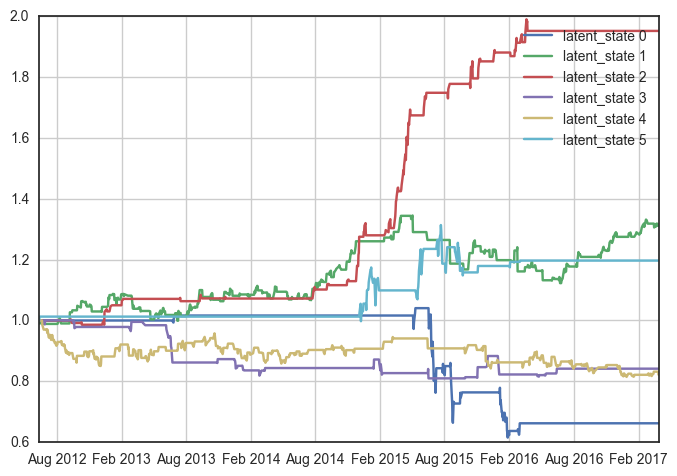

In [10]:
data = pd.DataFrame({'datelist':datelist,'logreturn':logreturn,'state':latent_states_sequence}).set_index('datelist')
for i in range(hmm.n_components):
    state = (latent_states_sequence == i)
    idx = np.append(0,state[:-1])
    data['state %d_return'%i] = data.logreturn.multiply(idx,axis = 0) 
    plt.plot(np.exp(data['state %d_return' %i].cumsum()),label = 'latent_state %d'%i) 
    plt.legend()
    plt.grid(1)

plt.show()

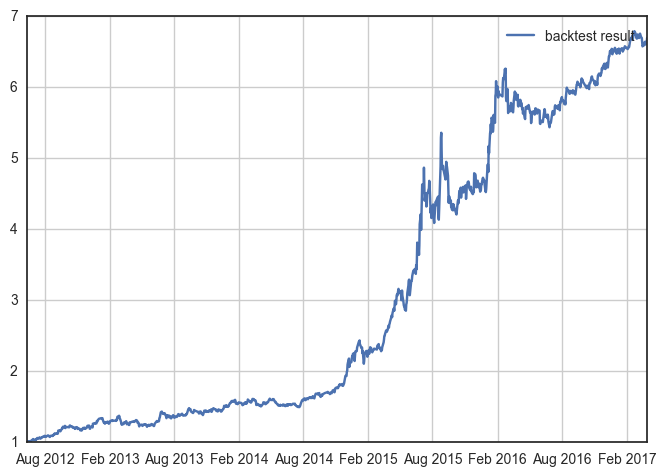

In [11]:
buy=0;
sell=0;
for i in range(hmm.n_components):
    temp=np.exp(data['state %d_return' %i].cumsum())
    if temp[-1]>1:
        buy=buy+(latent_states_sequence == i)
    if temp[-1]<1:
        sell=sell+(latent_states_sequence == i)
buy = np.append(0,buy[:-1])
sell = np.append(0,sell[:-1])
data['backtest_return'] = data.logreturn.multiply(buy,axis = 0) \
                             - data.logreturn.multiply(sell,axis = 0)
plt.plot_date(datelist,np.exp(data['backtest_return'].cumsum()),'-',label='backtest result')
plt.legend()
plt.grid(1)
plt.show()

In [12]:
backtest=np.exp(data['backtest_return'].cumsum())
retracement=0;
high=0;
for i in range(len(backtest)):
    if backtest[i]>high:
        high=backtest[i]
    temp=1-backtest[i]/high
    if temp>retracement:
        retracement=temp
print('Total return:',backtest[-1])
print('retracement:', retracement)
print('return to retracement:', backtest[-1]/retracement)


Total return: 6.66616575729
retracement: 0.214689875505
return to retracement: 31.0502101769


In [13]:
#success rate
predict_index=buy-sell
success=0
for i in range(len(predict_index)):
    if (logreturn[i]*predict_index[i]>=0):
        success=success+1;
success_rate=success/len(predict_index)
print('success rate:',success_rate)

success rate: 0.5457656116338752
